# Google Colab / Kaggle / PC

In [1]:
mode = "Colab"

In [2]:
import os

if mode == "Colab":
    from google.colab import drive
    drive.mount('/content/gdrive')
    os.chdir("/content/gdrive/My Drive/FPL_ML")
    TRAIN_PATH = "data/final_dataset.csv"
if mode == "PC":
    os.chdir("D:\PulpitE\FPL_ML")
    TRAIN_PATH = "data/final_dataset.csv"
if mode == "Kaggle":
    TRAIN_PATH = "/kaggle/input/fpl-dataset/final_dataset.csv"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Imports

In [3]:
import pandas as pd

import torch
import torch.nn as nn

import torchvision
import torchvision.transforms
from torchvision.transforms import ToTensor

from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

import matplotlib.pyplot as plt

import numpy as np
import random

# Constants and seeds

In [4]:
# FIXTURES_IN_SAMPLE
FIS = 8

# FIXTURES_FOR_PLAYER - minimal number of gameweeks required for a player
FFP = 15

FIRST_TRAIN_GW = 1
LAST_TRAIN_GW = 20

FIRST_VALID_GW = 21
LAST_VALID_GW = 21

# NEXT_GAMEWEEK = 22
# LAST_GAMEWEEK = NEXT_GAMEWEEK - 1

In [5]:
def set_all_seeds(seed):
    os.environ["PL_GLOBAL_SEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

set_all_seeds(42)

# Device

In [6]:
device = torch.device("cuda")
# device = torch.device('mps')
# device = torch.device('cpu')

# Getting data and choosing features

In [7]:
df = pd.read_csv('data/final_dataset.csv')

In [8]:
# remembering original dataframes
df_original = df

df_gk_original = df[df["FPL position"] == "GK"]
df_def_original = df[df["FPL position"] == "DEF"]
df_mid_original = df[df["FPL position"] == "MID"]
df_fwd_original = df[df["FPL position"] == "FWD"]

In [9]:
df_original.columns

Index(['Unnamed: 0', 'Date', 'Day', 'Comp', 'Round', 'Venue', 'Squad',
       'Opponent', 'Start', 'Pos', 'Min', 'Gls', 'Ast', 'PK', 'PKatt', 'Sh',
       'SoT', 'CrdY', 'CrdR', 'Touches', 'Tkl', 'Int', 'Blocks', 'xG', 'npxG',
       'xAG', 'SCA', 'GCA', 'Cmp', 'Att', 'Cmp%', 'PrgP', 'Carries', 'PrgC',
       'Att.1', 'Succ', 'Match Report', 'Name', 'Season', 'WDL', 'GoalsTeams',
       'Team Score', 'Opp Score', 'CS', 'Was Home', 'GW', 'FPL',
       'neutral_name', 'Total Points', 'FPL position', 'Opp rating',
       'ScoreForLast5', 'ScoreAgainstLast5'],
      dtype='object')

In [10]:
# df_original[df_original["Name"] == "Erling-Haaland"]

In [11]:
# df.iloc[0]

In [12]:
# df = df[df["Name"].isin(["Brenden-Aaronson", "Erling-Haaland", "Nick-Pope", "Kieran-Trippier"])]

In [13]:
info = ["Name", "GW", "FPL position"]
other = ["LSTM"]
features = ["Min", "Gls", "Ast", "Sh", "SoT", "xG", "npxG", "xAG", "SCA", "GCA", "CS", "CrdY", "CrdR", "Opp rating", "Team Score", "Opp Score", "Was Home"]
to_predict = ["Total Points"]

In [14]:
df = df[info + features + to_predict]
df[features + to_predict] = df[features + to_predict].astype("float32")

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [15]:
df.shape

(7457, 21)

In [16]:
# removing NaN rows and players that appear less than 15 times
df = df.dropna()
grouped = df.groupby('Name')

# taking only players with at least FFP matches in logs
df = grouped.filter(lambda x: len(x) >= FFP)

In [17]:
df.shape

(5771, 21)

In [18]:
# df.head(20)

In [19]:
last_names = df["Name"].unique()

In [20]:
df.columns

Index(['Name', 'GW', 'FPL position', 'Min', 'Gls', 'Ast', 'Sh', 'SoT', 'xG',
       'npxG', 'xAG', 'SCA', 'GCA', 'CS', 'CrdY', 'CrdR', 'Opp rating',
       'Team Score', 'Opp Score', 'Was Home', 'Total Points'],
      dtype='object')

In [21]:
df["FPL position"].unique()

array(['MID', 'FWD', 'DEF', 'GK'], dtype=object)

# DF to DataLoader

In [22]:
df_train = df[df["GW"] <= LAST_TRAIN_GW]
df_valid = df

# gk, def, mid, fwd
df_gk_train = df[(df["FPL position"] == "GK") & (df["GW"] <= LAST_TRAIN_GW)]
df_gk_valid = df[(df["FPL position"] == "GK") ]

df_def_train = df[(df["FPL position"] == "DEF") & (df["GW"] <= LAST_TRAIN_GW)]
df_def_valid = df[(df["FPL position"] == "DEF") ]

df_mid_train = df[(df["FPL position"] == "MID") & (df["GW"] <= LAST_TRAIN_GW)]
df_mid_valid = df[(df["FPL position"] == "MID") ]

df_fwd_train = df[(df["FPL position"] == "FWD") & (df["GW"] <= LAST_TRAIN_GW)]
df_fwd_valid = df[(df["FPL position"] == "FWD")]

In [23]:
# df_train

In [24]:
# df_gk.iloc[0]

In [25]:
def init_index_table(df):
    names = df["Name"].unique()
    result_dict = {}
    
    current_index = 0
    player_index = 0
    
    for name in names:
        sample_index = 0
        samples_for_names = df[df["Name"] == name].shape[0] - FIS
        for i in range(samples_for_names):
            result_dict[current_index] = [player_index, sample_index]
            current_index += 1
            sample_index += 1
        player_index += 1
    
    return result_dict

In [26]:
class PandasDataset(Dataset):
    def __init__(self, dataframe, starting_gw, ending_gw):
        self.dataframe = dataframe
        self.names = dataframe["Name"].unique()
        
        self.starting_gw = starting_gw
        self.ending_gw = ending_gw
        self.cut_unused_rows()
        self.length = self.calculate_length()

        self.index_table = init_index_table(self.dataframe)
        self.transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

    def cut_unused_rows(self):
        for name in self.names:
            df_name = self.dataframe[self.dataframe["Name"] == name]
            name_length = df_name.shape[0]
            # print("NAME LENGTH", name, name_length, FIS + 1)
            if name_length >= FIS + 1:
                try:
                    first_index = df_name.index.tolist()[0]
                except IndexError:
                    first_index = None

                try:
                    last_index = max(FIS, df_name.index[df_name['GW'] < self.starting_gw].tolist()[-1]) - FIS
                except:
                    last_index = None

                # print("FIRST LAST INDEX", name, first_index, last_index)
                if first_index != None and last_index != None:
                    # print("WYCIETO", name, range(first_index, last_index + 1))
                    self.dataframe = self.dataframe.drop(range(first_index, last_index + 1))
            else:
                # print("DROPPING", name, [df_name.index.tolist()])
                self.dataframe = self.dataframe.drop([df_name.index.tolist()])
                

            # print("CUTTING", name, first_index, last_index, name_length)
            # print("CUT2", df_name.index[df_name['GW'] < self.starting_gw].tolist())
            # print(self.dataframe.shape)
            # print("")

    def calculate_length(self):
        length = 0
        for name in self.names:
            # print(name, (self.dataframe[self.dataframe["Name"] == name].shape[0] - FIS))
            length += (self.dataframe[self.dataframe["Name"] == name].shape[0] - FIS)
        return length

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        # print(idx)
        player_id, sample_id = self.index_table[idx]
        name = self.names[player_id]
        # print(name)
        # print("GETITEM DF", name, player_id, sample_id)

        features = self.dataframe[self.dataframe["Name"] == name]
        # print(self.dataframe[self.dataframe["Name"] == name])
        # print(features[sample_id: (sample_id + 4)])
        features = features[sample_id: (sample_id + FIS)].drop(columns=info).values[:, :-1]
        # print(features)
        # print(features)
        # print(type(features))
        # print(self.dataframe[self.dataframe["Name"] == name].values[:, -1])
        # print(type(self.dataframe[self.dataframe["Name"] == name].values[:, -1]))
        # target = self.dataframe[self.dataframe["Name"] == name].values[:, -1]
        # target = target.astype(np.float32)
        # target = torch.from_numpy(target)
        # print("GETITEM", idx, player_id, sample_id, name)
        target = np.float32(self.dataframe[self.dataframe["Name"] == name].values[(sample_id + FIS), -1])
        # print(name, idx, target, sample_id)
        # print(type(target))
        return features, target

In [27]:
# df[["Name", "FPL position"]].drop_duplicates().head(20)

In [28]:
dataset_general_train = PandasDataset(df_train, FIRST_TRAIN_GW, LAST_TRAIN_GW)
dataset_general_valid = PandasDataset(df_valid, FIRST_VALID_GW, LAST_VALID_GW)

dataset_gk_train = PandasDataset(df_gk_train, FIRST_TRAIN_GW, LAST_TRAIN_GW)
dataset_gk_valid = PandasDataset(df_gk_valid, FIRST_VALID_GW, LAST_VALID_GW)

dataset_def_train = PandasDataset(df_def_train, FIRST_TRAIN_GW, LAST_TRAIN_GW)
dataset_def_valid = PandasDataset(df_def_valid, FIRST_VALID_GW, LAST_VALID_GW)

dataset_mid_train = PandasDataset(df_mid_train, FIRST_TRAIN_GW, LAST_TRAIN_GW)
dataset_mid_valid = PandasDataset(df_mid_valid, FIRST_VALID_GW, LAST_VALID_GW)

dataset_fwd_train = PandasDataset(df_fwd_train, FIRST_TRAIN_GW, LAST_TRAIN_GW)
dataset_fwd_valid = PandasDataset(df_fwd_valid, FIRST_VALID_GW, LAST_VALID_GW)

In [29]:
# dataset_fwd_valid.dataframe

In [30]:
# dataset_general_valid.dataframe

In [31]:
# dataset_fwd_valid.__getitem__(0)

In [32]:
# df

In [33]:
# df[df["Name"].isin(["Erling-Haaland"])].index.tolist()[0]

In [34]:
# dataset_general_train.__len__(), dataset_general_valid.__len__()

In [35]:
dataset_gk_train.__len__(), dataset_gk_valid.__len__()

(280, 25)

In [36]:
dataset_def_train.__len__(), dataset_def_valid.__len__()

(1035, 100)

In [37]:
dataset_mid_train.__len__(), dataset_mid_valid.__len__()

(1346, 123)

In [38]:
dataset_fwd_train.__len__(), dataset_fwd_valid.__len__()

(326, 30)

In [39]:
# dataset_general_valid.index_table

In [40]:
# dataset_fwd_valid.dataframe

In [41]:
# dataset_general_train.dataframe

In [42]:
# dataset_general_train.__getitem__(10)

In [43]:
# dataset_general_train.dataframe

In [44]:
batch_size = 16

In [45]:
dataloader_general_train = DataLoader(dataset_general_train, batch_size=batch_size, shuffle=False)
dataloader_general_valid = DataLoader(dataset_general_valid, batch_size=batch_size, shuffle=False)

dataloader_gk_train = DataLoader(dataset_gk_train, batch_size=batch_size, shuffle=False)
dataloader_def_train = DataLoader(dataset_def_train, batch_size=batch_size, shuffle=False)
dataloader_mid_train = DataLoader(dataset_mid_train, batch_size=batch_size, shuffle=False)
dataloader_fwd_train = DataLoader(dataset_fwd_train, batch_size=batch_size, shuffle=False)

dataloader_gk_valid = DataLoader(dataset_gk_valid, batch_size=batch_size, shuffle=False)
dataloader_def_valid = DataLoader(dataset_def_valid, batch_size=batch_size, shuffle=False)
dataloader_mid_valid = DataLoader(dataset_mid_valid, batch_size=batch_size, shuffle=False)
dataloader_fwd_valid = DataLoader(dataset_fwd_valid, batch_size=batch_size, shuffle=False)

In [46]:
len(dataloader_general_train), len(dataloader_gk_train), len(dataloader_def_train), len(dataloader_mid_train), len(dataloader_fwd_train)

(187, 18, 65, 85, 21)

In [47]:
len(dataloader_general_valid), len(dataloader_gk_valid), len(dataloader_def_valid), len(dataloader_mid_valid), len(dataloader_fwd_valid)

(18, 2, 7, 8, 2)

# LSTM Model

In [48]:
class LSTMNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.2):
        super(LSTMNetwork, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.transpose(x, 0, 1)
        # x = x.view(-1, batch_size)
        # x = torch.transpose(x, 0, 1)
        # print("FOR", x.shape)
        # print(x.shape)
        # print(x.shape)
        out, _ = self.lstm(x)
        # print(out.shape)
        out = self.fc(out[-1])
        return out

# Training loops

In [49]:
criterion = nn.MSELoss()

In [50]:
def train_net(net, num_epochs, dataloader, optimizer):
    if len(dataloader) <= 0:
        print("Dataloader has no elements")
        return []
    loss_history = []
    for epoch in range(num_epochs):
        running_loss = 0
        for i, (inputs, targets) in enumerate(dataloader):
            inputs = torch.flatten(inputs, 1, 2)
            inputs = inputs.unsqueeze(2).to(device)
            targets = targets.to(device)
            # print("INPUTS", inputs.shape)
            # print("TARGETS", targets.shape)
            # print(targets)
            optimizer.zero_grad()
            outputs = net(inputs).flatten().to(device)
            # print("OUTPUTS", outputs.shape)
            loss = criterion(outputs, targets)
            running_loss += loss.item()
            loss.backward()
            optimizer.step()

        loss_history.append(running_loss / len(dataloader))
        if epoch % 5 == 0:
            print(f'Epoch {epoch} Loss: {running_loss / len(dataloader)}')
    
    return loss_history

In [51]:
def plot_loss_history(loss_history):
    plt.plot(loss_history)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

## Training loop - general net

In [52]:
%%time
net = LSTMNetwork(1, 20, 2, 1, dropout=0.4).to(device)
optimizer = optim.Adam(net.parameters(), lr=0.005)
loss_history = train_net(net, 10, dataloader_general_train, optimizer)

Epoch 0 Loss: 9.059177205524342
Epoch 5 Loss: 8.828425352586144
CPU times: user 1min 7s, sys: 2.66 s, total: 1min 10s
Wall time: 1min 13s


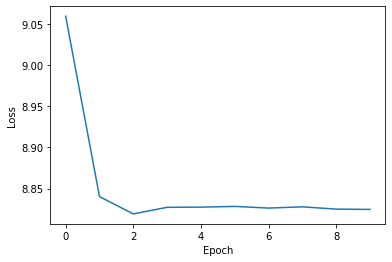

In [53]:
plot_loss_history(loss_history)

## Training loop - goalkeeper net

In [54]:
net_gk = LSTMNetwork(1, 20, 2, 1, dropout=0.4).to(device)

In [55]:
%%time
optimizer_gk = optim.Adam(net_gk.parameters(), lr=0.01)
loss_history_gk = train_net(net_gk, 5, dataloader_gk_train, optimizer_gk)

Epoch 0 Loss: 13.01942851808336
CPU times: user 2.03 s, sys: 32.7 ms, total: 2.06 s
Wall time: 2.04 s


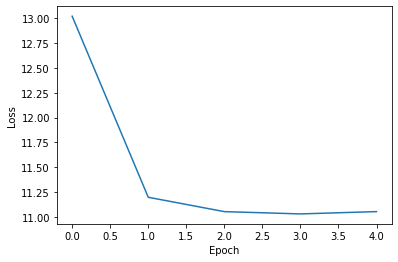

In [56]:
plot_loss_history(loss_history_gk)

## Training loop - defender net

In [57]:
net_def = LSTMNetwork(1, 20, 2, 1, dropout=0.4).to(device)

In [58]:
%%time
optimizer_def = optim.Adam(net_def.parameters(), lr=0.005)
loss_history_def = train_net(net_def, 5, dataloader_def_train, optimizer_def)

Epoch 0 Loss: 9.082968819141389
CPU times: user 1.7 s, sys: 23.1 ms, total: 1.72 s
Wall time: 1.71 s


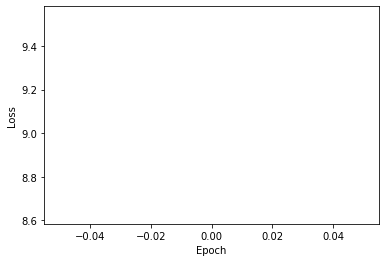

In [59]:
plot_loss_history(loss_history_def)

## Training loop - midfielder net

In [60]:
net_mid = LSTMNetwork(1, 20, 2, 1, dropout=0.4).to(device)

In [61]:
%%time
optimizer_mid = optim.Adam(net_mid.parameters(), lr=0.005)
loss_history_mid = train_net(net_mid, 5, dataloader_mid_train, optimizer_mid)

Epoch 0 Loss: 9.201869449895971
CPU times: user 5.45 s, sys: 52.7 ms, total: 5.5 s
Wall time: 6.68 s


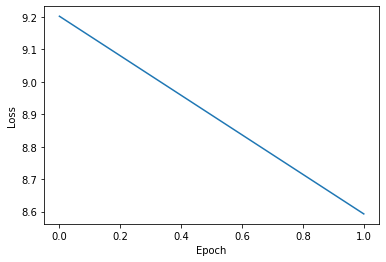

In [62]:
plot_loss_history(loss_history_mid)

## Training loop - forward net

In [63]:
net_fwd = LSTMNetwork(1, 20, 2, 1, dropout=0.5).to(device)

In [64]:
%%time
optimizer_fwd = optim.Adam(net_fwd.parameters(), lr=0.001)
loss_history_fwd = train_net(net_fwd, 5, dataloader_fwd_train, optimizer_fwd)

Epoch 0 Loss: 16.829788403851644
CPU times: user 999 ms, sys: 19 ms, total: 1.02 s
Wall time: 1.38 s


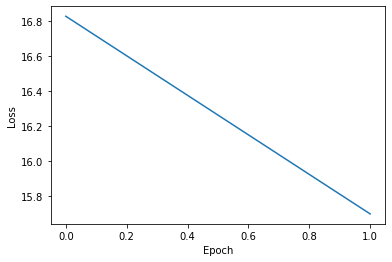

In [65]:
plot_loss_history(loss_history_fwd)

# Metrics

In [66]:
# general model


# Saving models to files

In [67]:
# general model
torch.save(net.state_dict(), 'models/lstm_general.pt')

# positional models
torch.save(net_gk.state_dict(), 'models/lstm_gk.pt')
torch.save(net_def.state_dict(), 'models/lstm_def.pt')
torch.save(net_mid.state_dict(), 'models/lstm_mid.pt')
torch.save(net_fwd.state_dict(), 'models/lstm_fwd.pt')

# Predictions - general model

In [68]:
def generate_predictions(dataloader_pos, dataset_pos, net_pos, df_original, first_gw):
    index = 0
    predictions_pos = []
    for inputs, target in dataloader_pos:
        inputs = torch.flatten(inputs, 1, 2)
        inputs = inputs.unsqueeze(2).to(device)

        # print("Inputs", inputs)
        # print("Target", target)
        # print("INPUTS", inputs)
        # print(inputs)
        outputs = net_pos(inputs).to(device)
        # print("OUTPUTS", outputs)
        for output in outputs:
            player_id, sample_id = dataset_pos.index_table[index]
            name = dataset_pos.names[player_id]
            points = round(output.item(), 2)
            # print("DFORW NEXT", player_id, sample_id, name, points)
            df_row = df_original[(df_original["Name"] == name) & (df_original["GW"] >= first_gw)].iloc[sample_id]
            # print("DFROW", df_row)
            df_row["Points"] = points
            df_gw = df_row["GW"]
            df_opp = df_row["Opponent"]

            # print("GEN PRED", player_id, sample_id, name, points, df_gw, df_opp)
            
            gw = sample_id + FIS + 1 # wrong
            predictions_pos.append(df_row)
            # df.loc[(df["Name"] == name) & (df["GW"] == gw), "LSTM"] = points
            index += 1
    
    output_df = pd.DataFrame(predictions_pos)
    output_df = output_df.loc[:, ~output_df.columns.str.contains('^Unnamed')]
    return output_df

In [69]:
prediction_columns = ["Name", "GW", "Opponent", "Was Home", "Total Points", "Points"]

In [70]:
predictions = generate_predictions(dataloader_general_valid, dataset_general_valid, net, df_original, FIRST_VALID_GW)

In [71]:
# dataset_general_valid.__getitem__(279)

In [72]:
predictions.sort_values(by=["Points"], ascending = False).head(20)[prediction_columns]

,Name,GW,Opponent,Was Home,Total Points,Points
18,Brenden-Aaronson,21,Brentford,1.0,3.0,2.82
2767,Sam-Greenwood,21,Brentford,1.0,1.0,2.82
2731,Demarai-Gray,21,West Ham,0.0,2.0,2.82
4584,Chris-Mepham,21,Nott'ham Forest,1.0,0.0,2.82
6928,Fabio-Vieira,21,Manchester Utd,1.0,0.0,2.82
2613,Morgan-Gibbs-White,21,Bournemouth,0.0,2.0,2.82
2558,David-de-Gea,21,Arsenal,0.0,1.0,2.82
2496,Conor-Gallagher,21,Liverpool,0.0,3.0,2.82
6566,James-Tarkowski,21,West Ham,0.0,0.0,2.82
2448,Fred,21,Arsenal,0.0,1.0,2.82


In [73]:
# # appending results to original df
# for df_gw, df_opp, name, gw, points in predictions:
#     df_original.loc[(df_original["Name"] == name) & (df["GW"] == gw), "LSTM"] = points

In [74]:
# df_original.to_csv("data/fpl_fbref_elo_lstm.csv")

# Predictions for each position

## Goalkeepers

In [75]:
predictions_gk = generate_predictions(dataloader_gk_valid, dataset_gk_valid, net_gk, df_gk_original, FIRST_VALID_GW)

In [76]:
# results sorted
predictions_gk.sort_values(by=["Points"], ascending = False).head(20)[prediction_columns]

,Name,GW,Opponent,Was Home,Total Points,Points
4000,Hugo-Lloris,21,Fulham,0.0,9.0,3.09
5725,Marek-Rodak,21,Tottenham,1.0,0.0,3.09
5516,David-Raya,21,Leeds United,0.0,10.0,3.09
2806,Vicente-Guaita,21,Newcastle Utd,1.0,10.0,3.08
6011,Robert-Sanchez,21,Leicester City,0.0,1.0,3.08
5403,Nick-Pope,21,Crystal Palace,0.0,6.0,3.08
4335,Emiliano-Martinez,21,Southampton,0.0,10.0,3.08
3862,Bernd-Leno,21,Tottenham,1.0,2.0,3.08
214,Alisson,21,Chelsea,1.0,9.0,3.08
2252,Lukasz-Fabianski,21,Everton,1.0,6.0,3.07


## Defenders

In [77]:
predictions_def = generate_predictions(dataloader_def_valid, dataset_def_valid, net_def, df_def_original, FIRST_VALID_GW)

In [78]:
len(dataset_def_valid.dataframe["Name"].unique())

110

In [79]:
dataset_def_valid.calculate_length()

100

In [80]:
i = 0
for name in dataset_def_valid.dataframe["Name"].unique():
    if dataset_def_valid.dataframe[dataset_def_valid.dataframe["Name"] == name].shape[0] >= 9:
      print(i, name, dataset_def_valid.dataframe[dataset_def_valid.dataframe["Name"] == name].shape)
      i += 1

0 Tosin-Adarabioyo (9, 21)
1 Rayan-Ait-Nouri (9, 21)
2 Nathan-Ake (9, 21)
3 Trent-Alexander-Arnold (9, 21)
4 Daniel-Amartey (9, 21)
5 Cesar-Azpilicueta (9, 21)
6 Willy-Boly (9, 21)
7 Sven-Botman (9, 21)
8 Hugo-Bueno (9, 21)
9 Dan-Burn (9, 21)
10 Joao-Cancelo (9, 21)
11 Matty-Cash (9, 21)
12 Timothy-Castagne (9, 21)
13 Jonny-Castro (9, 21)
14 Trevoh-Chalobah (9, 21)
15 Calum-Chambers (9, 21)
16 Nathaniel-Clyne (9, 21)
17 Conor-Coady (9, 21)
18 Seamus-Coleman (9, 21)
19 Nathan-Collins (9, 21)
20 Steve-Cook (9, 21)
21 Vladimir-Coufal (9, 21)
22 Aaron-Cresswell (9, 21)
23 Marc-Cucurella (9, 21)
24 Ben-Davies (9, 21)
25 Ruben-Dias (9, 21)
26 Eric-Dier (9, 21)
27 Issa-Diop (9, 21)
28 Matt-Doherty (9, 21)
29 Gabriel-Dos-Santos (9, 21)
30 Lewis-Dunk (9, 21)
31 Emerson (9, 21)
32 Pervis-Estupinan (9, 21)
33 Toti-Gomes (9, 21)
34 Joe-Gomez (9, 21)
35 Marc-Guehi (9, 21)
36 Rico-Henry (9, 21)
37 Rob-Holding (9, 21)
38 Ben-Johnson (9, 21)
39 Mathias-Jorgensen (9, 21)
40 Thilo-Kehrer (9, 21)
41 Max-

In [81]:
dataset_def_valid.__getitem__(49)

(array([[9.0000000e+01, 0.0000000e+00, 0.0000000e+00, 2.0000000e+00,
         1.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 1.0000000e+00,
         0.0000000e+00, 1.9162506e+03, 1.0000000e+00, 1.0000000e+00,
         1.0000000e+00],
        [9.0000000e+01, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 1.0000000e+00,
         0.0000000e+00, 1.7513988e+03, 0.0000000e+00, 1.0000000e+00,
         0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
         0.0000000e+00, 1.8236182e+03, 1.0000000e+00, 4.0000000e+00,
         1.0000000e+00],
        [1.9000000e+01, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
         0.0000000e+00, 0.00

In [82]:
# dataset_def_valid.index_table

In [83]:
dataset_def_valid.__getitem__(100)

(array([[9.0000000e+01, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00, 1.0000000e+00, 0.0000000e+00,
         0.0000000e+00, 1.7037889e+03, 2.0000000e+00, 0.0000000e+00,
         1.0000000e+00],
        [9.0000000e+01, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
         0.0000000e+00, 1.6557627e+03, 3.0000000e+00, 1.0000000e+00,
         1.0000000e+00],
        [9.0000000e+01, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
         0.0000000e+00, 1.9969723e+03, 0.0000000e+00, 1.0000000e+00,
         0.0000000e+00],
        [9.0000000e+01, 1.0000000e+00, 0.0000000e+00, 2.0000000e+00,
         1.0000000e+00, 3.00

In [84]:
# results sorted
predictions_def.sort_values(by=["Points"], ascending = False).head(20)[prediction_columns]

,Name,GW,Opponent,Was Home,Total Points,Points
4537,Ben-Mee,21,Leeds United,0.0,6.0,2.61
6282,Adam-Smith,21,Nott'ham Forest,1.0,2.0,2.61
6234,Thiago-Silva,21,Liverpool,0.0,6.0,2.60
869,Sven-Botman,21,Crystal Palace,0.0,6.0,2.60
7104,Adam-Webster,21,Leicester City,0.0,0.0,2.60
1183,Jonny-Castro,21,Manchester City,0.0,0.0,2.59
3071,Rico-Henry,21,Leeds United,0.0,6.0,2.59
7050,Joel-Ward,21,Newcastle Utd,1.0,6.0,2.59
4097,Lyanco,21,Aston Villa,1.0,1.0,2.59
5027,Angelo-Ogbonna,21,Everton,1.0,7.0,2.59


## Midfielders

In [85]:
predictions_mid = generate_predictions(dataloader_mid_valid, dataset_mid_valid, net_mid, df_mid_original, FIRST_VALID_GW)

In [86]:
# results sorted
predictions_mid.sort_values(by=["Points"], ascending = False).head(20)[prediction_columns]

,Name,GW,Opponent,Was Home,Total Points,Points
4763,Mason-Mount,21,Liverpool,0.0,3.0,3.14
2448,Fred,21,Arsenal,0.0,1.0,3.14
7306,Granit-Xhaka,21,Manchester Utd,1.0,5.0,3.14
308,Elliot-Anderson,21,Crystal Palace,0.0,0.0,3.14
5204,Thomas-Partey,21,Manchester Utd,1.0,2.0,3.14
4969,Matheus-Nunes,21,Manchester City,0.0,2.0,3.14
3366,Joelinton,21,Crystal Palace,0.0,2.0,3.14
1873,Moussa-Djenepo,21,Aston Villa,1.0,1.0,3.13
1688,Kevin-De-Bruyne,21,Wolves,1.0,6.0,3.13
2947,Jack-Harrison,21,Brentford,1.0,3.0,3.13


## Forwards

In [87]:
predictions_fwd = generate_predictions(dataloader_fwd_valid, dataset_fwd_valid, net_fwd, df_fwd_original, FIRST_VALID_GW)

In [88]:
# results sorted
predictions_fwd.sort_values(by=["Points"], ascending = False).head(20)[prediction_columns]

,Name,GW,Opponent,Was Home,Total Points,Points
2904,Erling-Haaland,21,Wolves,1.0,17.0,0.69
6959,Carlos-Vinicius,21,Tottenham,1.0,1.0,0.67
3501,Harry-Kane,21,Fulham,0.0,6.0,0.66
3401,Brennan-Johnson,21,Bournemouth,0.0,5.0,0.65
38,Che-Adams,21,Aston Villa,1.0,2.0,0.64
431,Adam-Armstrong,21,Aston Villa,1.0,2.0,0.64
256,Julian-Alvarez,21,Wolves,1.0,1.0,0.64
1569,Patson-Daka,21,Brighton,1.0,1.0,0.63
6516,Sam-Surridge,21,Bournemouth,0.0,8.0,0.63
3225,Danny-Ings,21,Everton,1.0,1.0,0.62
